# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import copy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
data['Time'] = pd.to_datetime(data['Time'].values, format='%m/%d/%Y')
data = data.set_index('Time')
## Calculate % Change of Closing Price
#data['ret_final']=(data['Close'].shift(-1)-data['Close'])/data['Close']
data['ret_final'] = data.Close.pct_change()
data['ret_final'] = data.fillna(0)
#data['label'] = [(1 if j>0 else 0) for j in data.ret_final]
def find_label(curr_close, prev_close):
    if curr_close < (0.98 * prev_close):
        return 'label_down_200'
    elif (curr_close < (0.985 * prev_close)) and (curr_close >= (0.98 * prev_close)):
        return 'label_static_down_150'
    elif (curr_close < (0.99 * prev_close)) and (curr_close >= (0.985 * prev_close)):
        return 'label_static_down_100'
    elif (curr_close < (0.995 * prev_close)) and (curr_close >= (0.99 * prev_close)):
        return 'label_static_down_50'
    elif (curr_close < prev_close) and (curr_close >= (0.995 * prev_close)):
        return 'label_static_down_0'
    elif (curr_close >= prev_close) and (curr_close < (1.005 * prev_close)):
        return 'label_static_up_0'
    elif (curr_close >= (1.005 * prev_close)) and (curr_close < (1.01 * prev_close)):
        return 'label_static_up_50'
    elif (curr_close >= (1.01 * prev_close)) and (curr_close < (1.015 * prev_close)):
        return 'label_static_up_100'
    elif (curr_close >= (1.015 * prev_close)) and (curr_close < (1.02 * prev_close)):
        return 'label_static_up_150'
    elif curr_close > (1.02 * prev_close):
        return 'label_up_200'
    else:
        return 'Unknown'


data['label'] = ['label_down_200'] + [find_label(data.Close[i], data.Close[i-1]) for i in range(1,len(data.Close))] 
#data = data[1:]
data = data.fillna(0)
data.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,...,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,ret_final,label
Time,,,,,,,,,,,,,,,,,,,,,
2008-10-15,14.83,15.29,13.98,13.99,387619900,0.0,-0.641,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.83,label_down_200
2008-10-16,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.25,label_up_200
2008-10-17,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.21,label_down_200
2008-10-20,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.26,label_static_up_100
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.86,label_down_200


In [3]:
print('Unique Labels : ', data.label.unique())
print()
print('Label Counts : ', Counter(data.label))
print()
print('Label Distribution in Data')
for key, val in Counter(data.label).items():
    print('%25s : %.2f%%'%(key, val*100/data.shape[0]))

Unique Labels :  ['label_down_200' 'label_up_200' 'label_static_up_100'
 'label_static_down_150' 'label_static_down_50' 'label_static_down_100'
 'label_static_up_150' 'label_static_up_0' 'label_static_up_50'
 'label_static_down_0']

Label Counts :  Counter({'label_static_down_0': 428, 'label_static_up_0': 410, 'label_static_up_50': 346, 'label_static_down_50': 318, 'label_up_200': 262, 'label_static_up_100': 256, 'label_down_200': 251, 'label_static_up_150': 189, 'label_static_down_100': 174, 'label_static_down_150': 122})

Label Distribution in Data
           label_down_200 : 9.11%
             label_up_200 : 9.51%
      label_static_up_100 : 9.29%
    label_static_down_150 : 4.43%
     label_static_down_50 : 11.54%
    label_static_down_100 : 6.31%
      label_static_up_150 : 6.86%
        label_static_up_0 : 14.88%
       label_static_up_50 : 12.55%
      label_static_down_0 : 15.53%


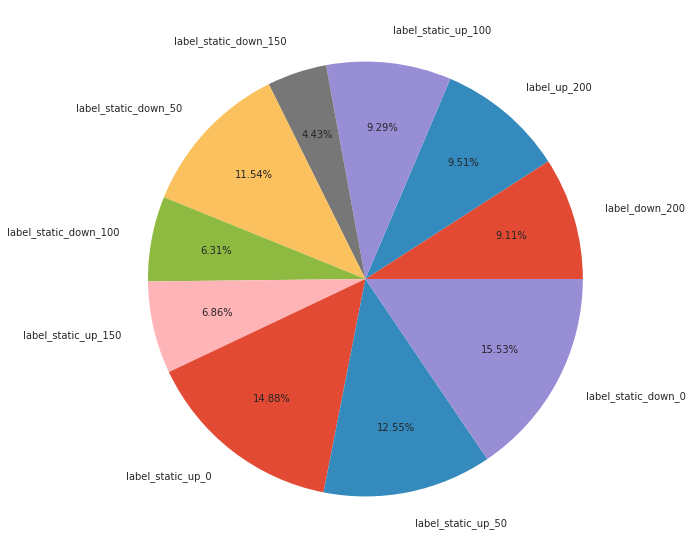

In [4]:
with plt.style.context(('seaborn','ggplot')):
    labels_dist = Counter(data.label)
    plt.figure(figsize=(10,10))
    plt.pie(x=labels_dist.values(), labels=labels_dist.keys(), autopct='%0.2f%%', pctdistance=0.7, radius=1.0, labeldistance=1.15)

In [5]:
target_col_order = ['label_down_200', 'label_static_down_150', 'label_static_down_100','label_static_down_50','label_static_down_0','label_static_up_0', \
'label_static_up_50', 'label_static_up_100','label_static_up_150','label_up_200']
label_to_idx = dict(zip(target_col_order, range(len(target_col_order))))
data['encoded_label'] = [label_to_idx[label] for label in data.label]

# Exploratory Data Analysis

## Correlation Between Features and Label/Returns/Close Price/Open Price

Below we have found out correlation between all feaatures and label, returns, close price and open price. We'll use this correlation for plotting purpose below.

In [6]:
corr_between_features_and_label = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15','encoded_label']].corr()

In [7]:
corr_between_features_and_label

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,encoded_label
feature1,1.000,0.402,0.107,0.768,0.792,-0.173,-0.173,-0.129,0.473,0.529,0.473,0.717,0.354,0.303,0.256,0.449
feature2,0.402,1.000,0.016,0.281,0.353,-0.011,-0.002,-0.008,0.069,0.102,0.069,0.172,0.088,0.113,0.050,0.765
feature3,0.107,0.016,1.000,0.314,-0.052,0.146,0.160,0.118,0.377,0.372,0.377,0.052,0.168,0.031,0.163,0.025
feature4,0.768,0.281,0.314,1.000,0.564,-0.215,-0.110,-0.188,0.805,0.842,0.805,0.556,0.416,0.206,0.355,0.325
feature5,0.792,0.353,-0.052,0.564,1.000,-0.052,-0.260,0.011,0.060,0.133,0.060,0.792,0.182,0.339,0.065,0.429
feature6,-0.173,-0.011,0.146,-0.215,-0.052,1.000,0.207,0.968,-0.285,-0.289,-0.285,-0.054,-0.160,0.007,-0.168,-0.034
feature7,-0.173,-0.002,0.160,-0.110,-0.260,0.207,1.000,-0.036,0.014,-0.002,0.014,-0.301,-0.177,-0.115,-0.142,-0.004
feature8,-0.129,-0.008,0.118,-0.188,0.011,0.968,-0.036,1.000,-0.290,-0.290,-0.290,0.019,-0.113,0.035,-0.131,-0.030
feature9,0.473,0.069,0.377,0.805,0.060,-0.285,0.014,-0.290,1.000,0.996,1.000,0.213,0.410,0.035,0.413,0.057
feature10,0.529,0.102,0.372,0.842,0.133,-0.289,-0.002,-0.290,0.996,1.000,0.996,0.268,0.421,0.061,0.414,0.097


Below bar charts show correlation value (Positive/Negative) between features and label, returns, close price and open price.

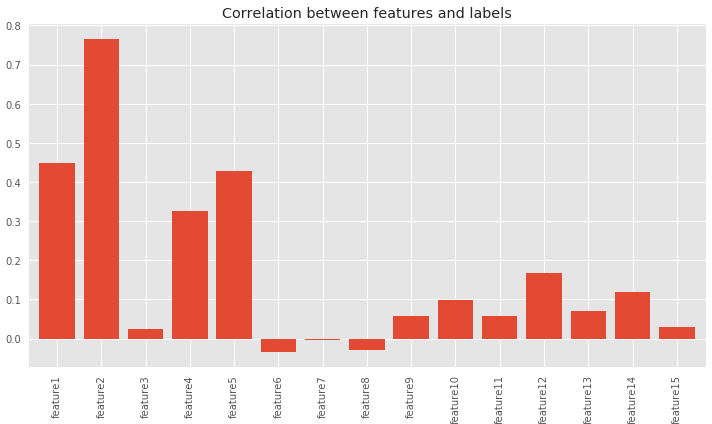

In [8]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(10,6))
    corr_between_features_and_label.loc['encoded_label',].drop('encoded_label').plot(kind='bar', width=0.8, title='Correlation between features and labels')
    
    plt.tight_layout()

Below heatmaps shows correlation between various features and label, returns and close price.

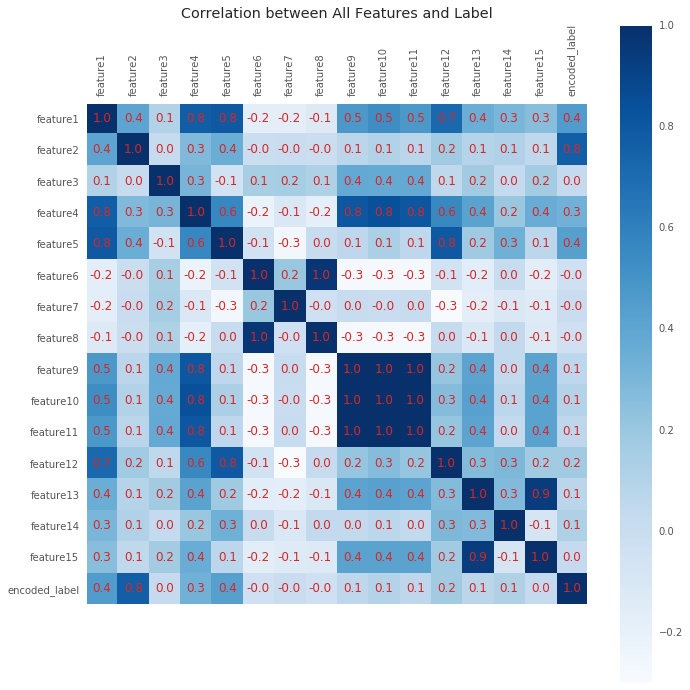

In [9]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=12);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=12);
                
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(10,10))
    plot_correlation_matrix(corr_between_features_and_label, 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

## P-value For Label, Returns and Close Price
Below we have plotted p-value and f-classif/f-regression values. Lower p-values generally indicates that that feature has high relation with target variable. Higher p-values incdicates that feature has less relation with target. You can compare this graph with above one.

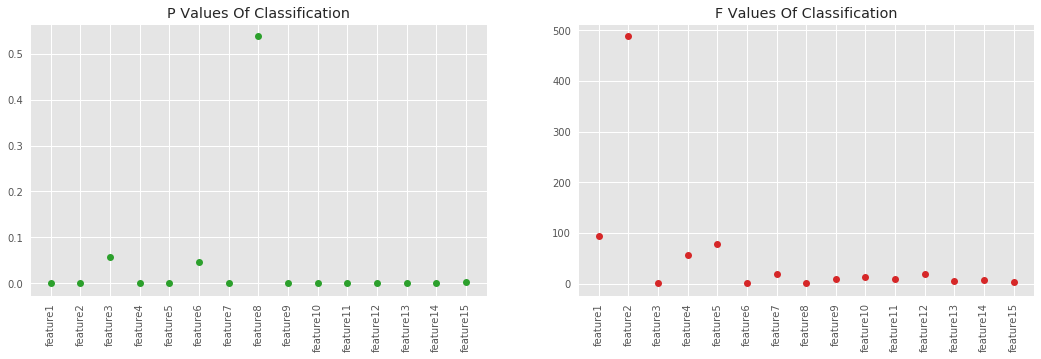

In [10]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
X = MinMaxScaler().fit_transform(X)
Y = data['encoded_label'].values

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,5))
    plt.subplot(121)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(122)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('F Values Of Classification');

# Dividing Data Into Train/Test Sets
We have selected 15 features are our main features for prediction and label column as predicting column. We'll divide dataset into `90%` for training and `10%` for test.

In [11]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
X = MinMaxScaler().fit_transform(X)
Y = data['encoded_label'].values
Y_one_hot = np_utils.to_categorical(data['encoded_label'].values)
ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)
X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.9, test_size=0.1, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train_one_hot.shape, Y_test_one_hot.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)
print(sorted(Counter(Y_train).items(), key=lambda x : x[0]))
print(sorted(Counter(Y_test).items(), key=lambda x: x[0]))

Train/Test Sizes :  (2480, 15) (276, 15) (2480,) (276,)
Train/Test Sizes :  (2480, 15) (276, 15) (2480, 10) (276, 10)
Actual Return Sizes :  (276,)
[(0, 219), (1, 107), (2, 158), (3, 288), (4, 394), (5, 376), (6, 307), (7, 228), (8, 171), (9, 232)]
[(0, 32), (1, 15), (2, 16), (3, 30), (4, 34), (5, 34), (6, 39), (7, 28), (8, 18), (9, 30)]


### Sanity Checks

In [12]:
print('Cheking that train data has all classes covered for model to learn as well as check distribution for test')
print(set(Y_train), set(Y_test))
print()
print(np.bincount(Y_train)*100/Y_train.shape[0])
print(np.bincount(Y_test)*100/Y_test.shape[0])

Cheking that train data has all classes covered for model to learn as well as check distribution for test
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

[ 8.831  4.315  6.371 11.613 15.887 15.161 12.379  9.194  6.895  9.355]
[11.594  5.435  5.797 10.87  12.319 12.319 14.13  10.145  6.522 10.87 ]


### Finance Metrics
Below are some of finance evaluation metrics

In [13]:
def WR(returns,predictions):
    total_trades = predictions.sum()
    wins= ((returns*predictions)>0).sum()
    return(wins/total_trades)

def ARR(returns,predictions):
    total_trades = predictions.sum()
    all_returns = returns*predictions
    total_return = all_returns.sum()
    gain=(total_return)/total_trades
    arr=((1+gain))**252-1
    useful_returns=[all_returns[j] for j in range(len(predictions)) if predictions[j]==1]
    sigma=np.std(np.array(useful_returns))
    asr=np.sqrt(252)*gain/sigma
    return([arr,asr])

def MDD(returns,predictions):
    all_returns= returns*predictions
    cum_vals=np.cumprod(all_returns+1)
    i = np.argmax(np.maximum.accumulate(cum_vals) - cum_vals) # end of the period
    j = np.argmax(cum_vals[:i]) # start of period
    mdd=(cum_vals[j]- cum_vals[i])/cum_vals[j]
    return(mdd)

### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [14]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks(range(len(target_col_order)), target_col_order, rotation='vertical')
        plt.yticks(range(len(target_col_order)), target_col_order)
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# DenseNet v1
Below dense model consist of 4 dense layers with dimensions 128, 64,32,1 respectively. For internal layers we have selected activation function as relu. Last layer has activation function as sigmoid because its classification problem.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

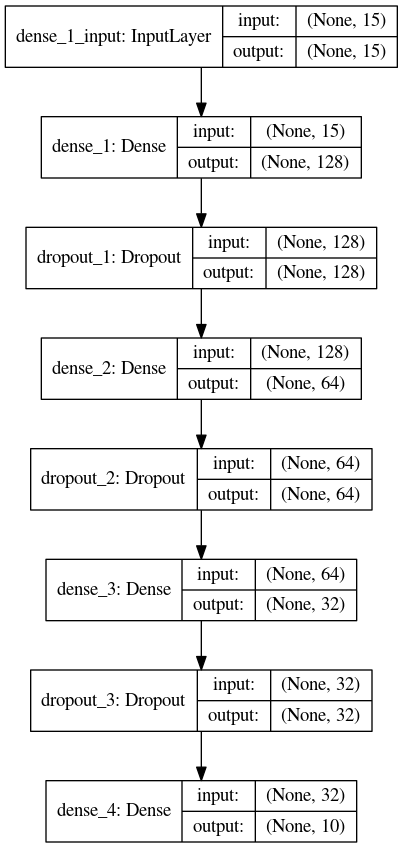

In [15]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(), 
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(Y_train_one_hot.shape[1],   activation='softmax')])

print(dense_model1.summary())
plot_model(dense_model1, to_file='dense1.png', show_shapes=True)
Image.open('dense1.png')

## Compiling Model
Compiling Model involves setting optimizers to use, loss and evaluation metrics.

In [16]:
dense_model1.compile('adam', loss='categorical_crossentropy', metrics = ['accuracy'])

## Fitting Model
Below we are fitting model with batch size of 4 for 25 epochs. We'll use 10% of train data as validation data for evaluation of performance during training.

In [17]:
history = dense_model1.fit(X_train, Y_train_one_hot, batch_size=4, epochs=30, validation_split=0.1, verbose=2,shuffle=False, use_multiprocessing=True);

Train on 2232 samples, validate on 248 samples
Epoch 1/30
 - 2s - loss: 2.1044 - accuracy: 0.1913 - val_loss: 1.7735 - val_accuracy: 0.3024
Epoch 2/30
 - 1s - loss: 1.8901 - accuracy: 0.2509 - val_loss: 1.6582 - val_accuracy: 0.3226
Epoch 3/30
 - 1s - loss: 1.8457 - accuracy: 0.2720 - val_loss: 1.6307 - val_accuracy: 0.3387
Epoch 4/30
 - 1s - loss: 1.7948 - accuracy: 0.2988 - val_loss: 1.5874 - val_accuracy: 0.3468
Epoch 5/30
 - 1s - loss: 1.7865 - accuracy: 0.2885 - val_loss: 1.5937 - val_accuracy: 0.3629
Epoch 6/30
 - 1s - loss: 1.7521 - accuracy: 0.3100 - val_loss: 1.5870 - val_accuracy: 0.3629
Epoch 7/30
 - 1s - loss: 1.7617 - accuracy: 0.3073 - val_loss: 1.5710 - val_accuracy: 0.3669
Epoch 8/30
 - 1s - loss: 1.7437 - accuracy: 0.3118 - val_loss: 1.5765 - val_accuracy: 0.3710
Epoch 9/30
 - 1s - loss: 1.7464 - accuracy: 0.3100 - val_loss: 1.5720 - val_accuracy: 0.3468
Epoch 10/30
 - 1s - loss: 1.7376 - accuracy: 0.3069 - val_loss: 1.5601 - val_accuracy: 0.3427
Epoch 11/30
 - 1s - lo

## Visualizing Training Stage Results

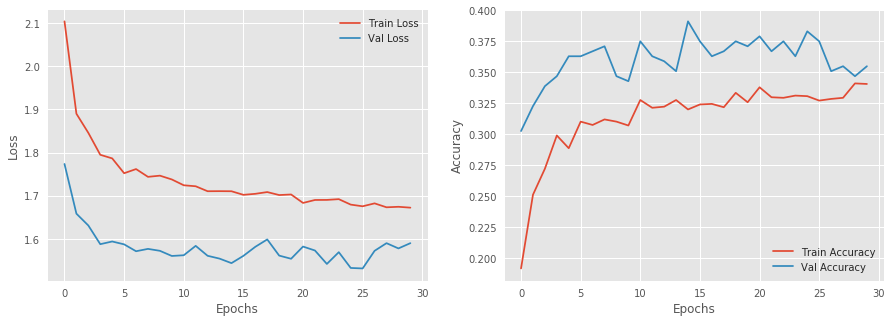

In [18]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [19]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.297


In [20]:
predictions_full = dense_model1.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.308


In [21]:
softmax_vals = dense_model1.predict_proba(X)
#print(softmax_vals[:,i].shape)
df1 = copy.deepcopy(data)
df1['Preds'] = predictions_full
for i, col in enumerate(target_col_order):
    df1[col + '_softmax'] = softmax_vals[:,i]

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        16
           3       0.17      0.23      0.20        30
           4       0.25      0.65      0.36        34
           5       0.20      0.47      0.28        34
           6       0.19      0.08      0.11        39
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        18
           9       0.59      0.33      0.43        30

    accuracy                           0.30       276
   macro avg       0.21      0.25      0.21       276
weighted avg       0.25      0.30      0.25       276

Confusion Matrix : 
 [[24  0  0  5  3  0  0  0  0  0]
 [ 0  0  0 10  4  0  0  0  0  1]
 [ 3  0  0  7  6  0  0  0  0  0]
 [ 1  0  1  7 19  2  0  0  0  0]
 [ 2  0  0  4 22  6  0  0  0  0]
 [ 2  0  0  1 14 16  1  0  0 

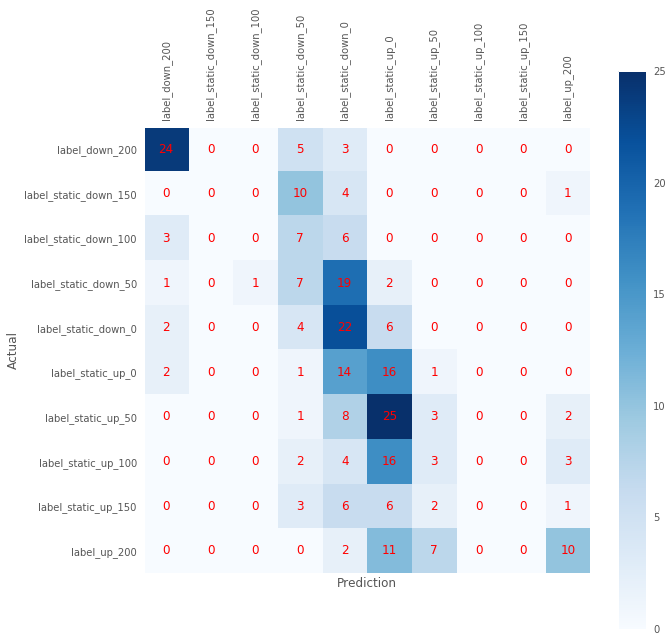

In [22]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    #wr_mlp, vals, mdd_mlp = WR(actual_rets_test,predictions), ARR(actual_rets_test,predictions), MDD(actual_rets_test,predictions)
    #arr_mlp, asr_mlp=vals[0], vals[1]
    #results.append([model_name, wr_mlp, arr_mlp, asr_mlp, mdd_mlp])

    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)

print_plot_metrics('DenseNetv1', actual_rets_test, Y_test, predictions)

## Visualising Weights
Below we are visualising average weights of first layer which has same shape as that of number of features.

Layer : Dense : Weights : (15, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 10)
Layer : Dense : Bias : (10,)


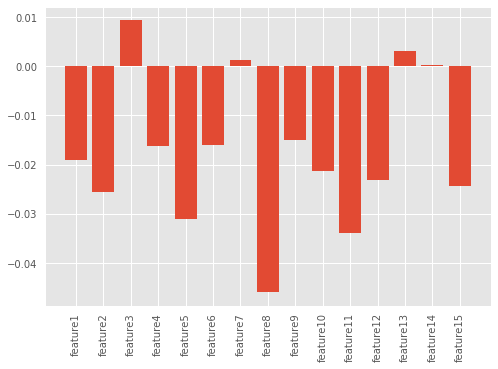

In [23]:
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

print_weights_per_layer(dense_model1)

dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# DenseNet v2
Below we have deisigned another dense net model which has 6 layers of shapes 512,256,128,64,32 and 1 respectively. We have used relu as activation function for internal layers and sigmoid for last layer. We also have used Dropout of 20% this time between each layer to see whether it help improve performance.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              32768     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

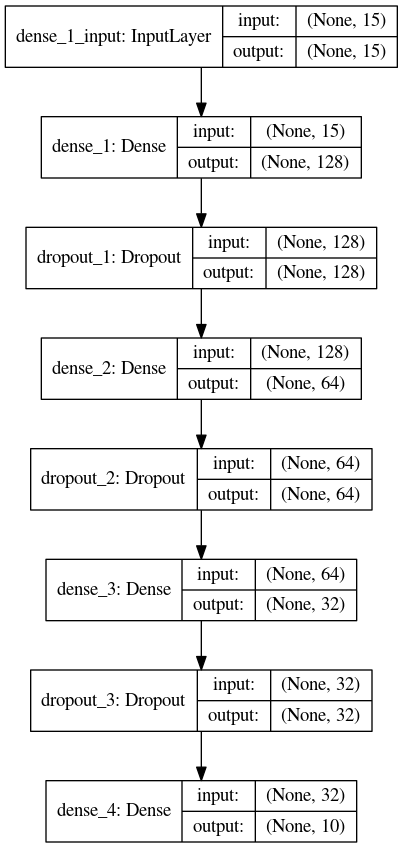

In [24]:
dense_model2 = Sequential([ 
                     Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.3),
                     Dense(1024,  activation='relu'),
                     Dropout(0.3),
                     Dense(512,  activation='relu'),
                     Dropout(0.3),
                     Dense(256,  activation='relu'),
                     Dropout(0.3),
                     Dense(128,  activation='relu'),
                     Dropout(0.3),
                     Dense(64,  activation='relu'),
                     Dropout(0.3),
                     Dense(32,  activation='relu'),
                     Dropout(0.3),
                     Dense(Y_train_one_hot.shape[1],   activation='softmax')])

print(dense_model2.summary())
plot_model(dense_model1, to_file='dense2.png', show_shapes=True)
Image.open('dense2.png')

## Compiling Model

In [25]:
dense_model2.compile('adam', loss='categorical_crossentropy', metrics = ['accuracy'])

## Fitting Model

In [26]:
history = dense_model2.fit(X_train, Y_train_one_hot, batch_size=4, epochs=25, validation_split=0.1, verbose=2,shuffle=False, use_multiprocessing=True);

Train on 2232 samples, validate on 248 samples
Epoch 1/25
 - 21s - loss: 2.2437 - accuracy: 0.1398 - val_loss: 2.0427 - val_accuracy: 0.2621
Epoch 2/25
 - 21s - loss: 2.0675 - accuracy: 0.1891 - val_loss: 1.8177 - val_accuracy: 0.2823
Epoch 3/25
 - 21s - loss: 1.9533 - accuracy: 0.2419 - val_loss: 1.6927 - val_accuracy: 0.3306
Epoch 4/25
 - 21s - loss: 1.9052 - accuracy: 0.2675 - val_loss: 1.6506 - val_accuracy: 0.3589
Epoch 5/25
 - 21s - loss: 1.8756 - accuracy: 0.2728 - val_loss: 1.6341 - val_accuracy: 0.3710
Epoch 6/25
 - 21s - loss: 1.8563 - accuracy: 0.2814 - val_loss: 1.6249 - val_accuracy: 0.3508
Epoch 7/25
 - 21s - loss: 1.8294 - accuracy: 0.2939 - val_loss: 1.6552 - val_accuracy: 0.3589
Epoch 8/25
 - 22s - loss: 1.8364 - accuracy: 0.2805 - val_loss: 1.6204 - val_accuracy: 0.3427
Epoch 9/25
 - 21s - loss: 1.8228 - accuracy: 0.2939 - val_loss: 1.6514 - val_accuracy: 0.3145
Epoch 10/25
 - 21s - loss: 1.8288 - accuracy: 0.2930 - val_loss: 1.6366 - val_accuracy: 0.3306
Epoch 11/25


## Visualising Training Stage Results

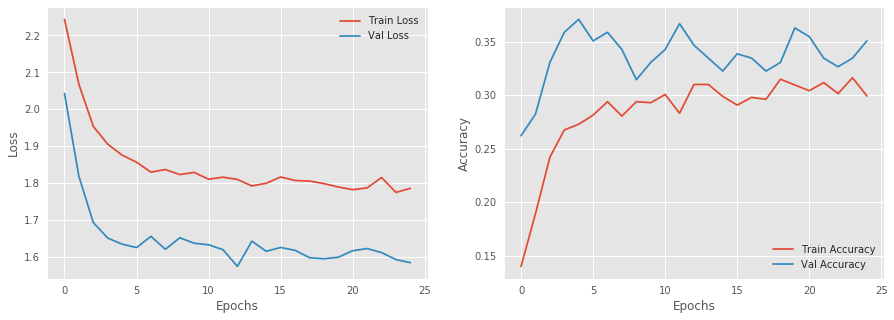

In [27]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [28]:
predictions = dense_model2.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.250


In [29]:
predictions_full = dense_model2.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.307


In [30]:
softmax_vals = dense_model2.predict_proba(X)
#print(softmax_vals[:,i].shape)
df2 = copy.deepcopy(data)
df2['Preds'] = predictions_full
for i, col in enumerate(target_col_order):
    df2[col + '_softmax'] = softmax_vals[:,i]

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.75      0.66      0.70        32
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        16
           3       0.18      0.23      0.21        30
           4       0.22      0.68      0.34        34
           5       0.12      0.21      0.15        34
           6       0.11      0.08      0.09        39
           7       0.22      0.14      0.17        28
           8       0.00      0.00      0.00        18
           9       0.80      0.13      0.23        30

    accuracy                           0.25       276
   macro avg       0.24      0.21      0.19       276
weighted avg       0.27      0.25      0.22       276

Confusion Matrix : 
 [[21  0  0 10  1  0  0  0  0  0]
 [ 1  0  0  9  4  0  1  0  0  0]
 [ 4  0  0  5  6  1  0  0  0  0]
 [ 1  0  0  7 20  2  0  0  0  0]
 [ 1  0  0  4 23  5  1  0  0  0]
 [ 0  0  0  2 22  7  3  0  0 

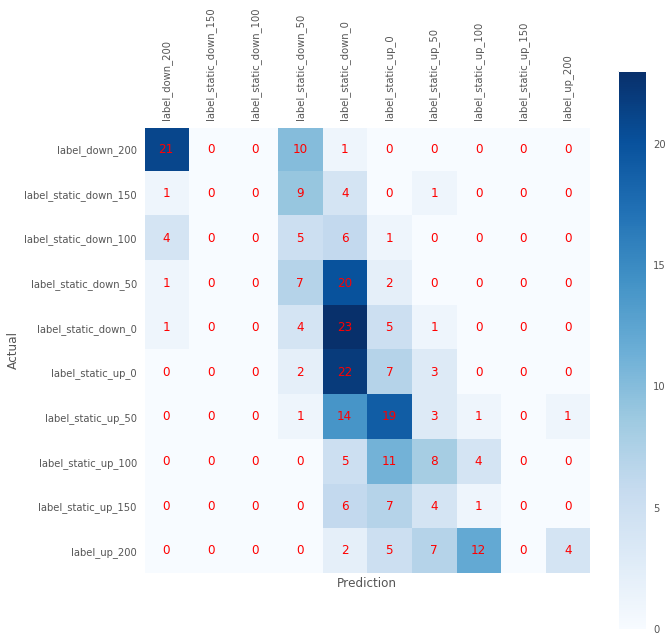

In [31]:
print_plot_metrics('DenseNetv2', actual_rets_test, Y_test, predictions)

Layer : Dense : Weights : (15, 2048)
Layer : Dense : Bias : (2048,)
Layer : Dense : Weights : (2048, 1024)
Layer : Dense : Bias : (1024,)
Layer : Dense : Weights : (1024, 512)
Layer : Dense : Bias : (512,)
Layer : Dense : Weights : (512, 256)
Layer : Dense : Bias : (256,)
Layer : Dense : Weights : (256, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 10)
Layer : Dense : Bias : (10,)


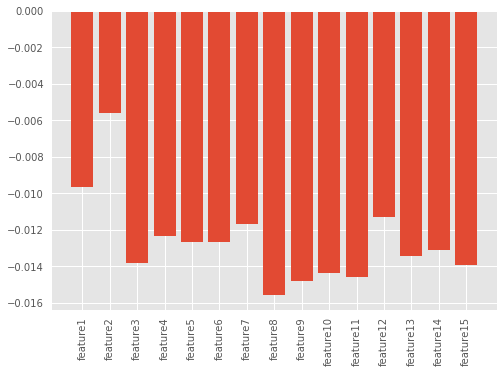

In [32]:
print_weights_per_layer(dense_model2)

dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v1

Below we are preparing data for LSTM. We are taking look back size of 50 so that we'll look at 50 previous sample to predict current one. We are organizing our dataset in that format so that it can be fed into LSTM.

In [33]:
def prepare_dataset(features,labels, look_back=1):
    X, Y = [], []
    for i in range(len(features)-look_back):
        a = features[i:(i+look_back), :]
        X.append(a)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
X = MinMaxScaler().fit_transform(X)
Y = data['encoded_label'].values
Y_one_hot = np_utils.to_categorical(data['encoded_label'].values)

ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Actual Data Size : ', X.shape, Y.shape)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
#print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train_one_hot.shape, Y_test_one_hot.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

# split into input and outputs
look_back = 50
X_train, Y_train = prepare_dataset(X_train, Y_train, look_back)
X_test, Y_test = prepare_dataset(X_test, Y_test, look_back)

X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.9, test_size=0.1, shuffle=False)

X_train, Y_train_one_hot = prepare_dataset(X_train, Y_train_one_hot, look_back)
X_test, Y_test_one_hot = prepare_dataset(X_test, Y_test_one_hot, look_back)

X_new, Y_new = prepare_dataset(X, Y, look_back)
print('Modified Data Size : ', X_new.shape, Y_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train_one_hot.shape, X_test.shape, Y_test_one_hot.shape)

Actual Data Size :  (2756, 15) (2756,)
Train/Test Sizes :  (2480, 15) (276, 15) (2480,) (276,)
Actual Return Sizes :  (276,)
Modified Data Size :  (2706, 50, 15) (2706,)
Train/Test Sizes Modified (2430, 50, 15) (2430,) (226, 50, 15) (226,)
Train/Test Sizes Modified (2430, 50, 15) (2430, 10) (226, 50, 15) (226, 10)


Below we have defined LSTM network of only 50 units. This parameter can be tweaked to check whether it improves performance further in future. My guess is that if we increase its value further then it'll performance. Output layer is again sigmoid.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
Total params: 13,710
Trainable params: 13,710
Non-trainable params: 0
_________________________________________________________________
None


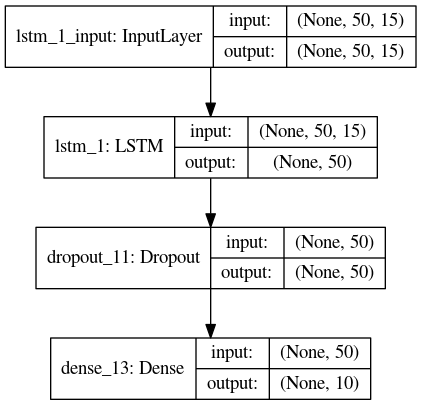

In [34]:
lstm_classif = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.3),
                        Dense(Y_train_one_hot.shape[1], activation='softmax')                        
                        ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif1.png', show_shapes=True)
Image.open('lstm_classif1.png')

## Compiling Model

In [35]:
lstm_classif.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [36]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=4, validation_split=0.1, verbose=2, shuffle=False)

Train on 2187 samples, validate on 243 samples
Epoch 1/30
 - 15s - loss: 2.2397 - accuracy: 0.1449 - val_loss: 2.1858 - val_accuracy: 0.2099
Epoch 2/30
 - 15s - loss: 2.2384 - accuracy: 0.1513 - val_loss: 2.1735 - val_accuracy: 0.2099
Epoch 3/30
 - 15s - loss: 2.2331 - accuracy: 0.1550 - val_loss: 2.1633 - val_accuracy: 0.2058
Epoch 4/30
 - 15s - loss: 2.2253 - accuracy: 0.1573 - val_loss: 2.1648 - val_accuracy: 0.2140
Epoch 5/30
 - 15s - loss: 2.2246 - accuracy: 0.1651 - val_loss: 2.1639 - val_accuracy: 0.2140
Epoch 6/30
 - 15s - loss: 2.2275 - accuracy: 0.1632 - val_loss: 2.1556 - val_accuracy: 0.2099
Epoch 7/30
 - 15s - loss: 2.2214 - accuracy: 0.1600 - val_loss: 2.1573 - val_accuracy: 0.2099
Epoch 8/30
 - 15s - loss: 2.2221 - accuracy: 0.1632 - val_loss: 2.1567 - val_accuracy: 0.1934
Epoch 9/30
 - 15s - loss: 2.2229 - accuracy: 0.1596 - val_loss: 2.1633 - val_accuracy: 0.2140
Epoch 10/30
 - 15s - loss: 2.2193 - accuracy: 0.1568 - val_loss: 2.1556 - val_accuracy: 0.2058
Epoch 11/30


## Visualizing Training Stage Results

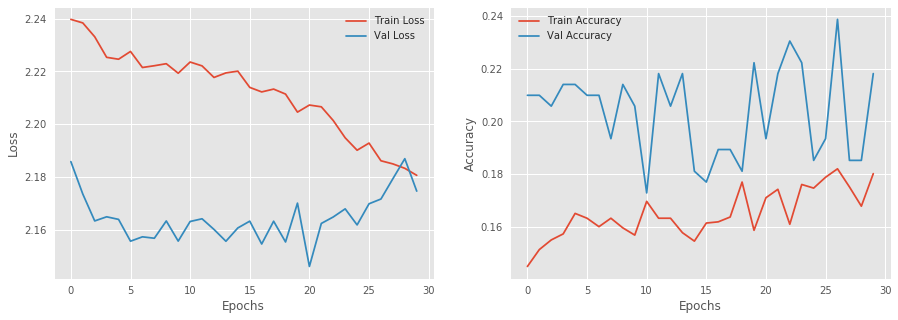

In [37]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [38]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.142


In [39]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))

Accuracy : 0.183


In [40]:
softmax_vals = lstm_classif.predict_proba(X_new)
#print(softmax_vals[:,i].shape)
df3 = copy.deepcopy(data)
df3['Preds'] = np.hstack((['label_down_200']*50, predictions_full))
for i, col in enumerate(target_col_order):
    df3[col + '_softmax'] = np.hstack((np.zeros(50), softmax_vals[:,i]))

## Printing/Plotting Classification Metrics

In [41]:
#print_plot_metrics('LSTMv1', actual_rets_test, Y_test, predictions)

## Visualising Weights

Layer : LSTM : Weights : (15, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


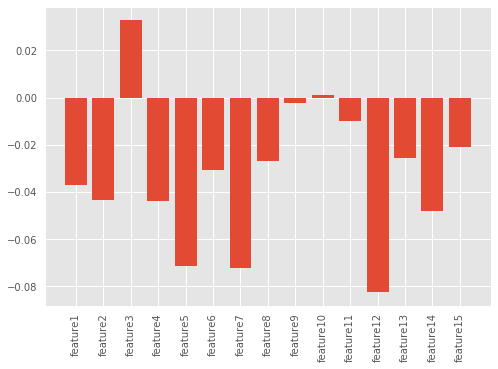

In [42]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v2
Below we have defined another LSTM model which has 3 LSTM layers of all same unit sizes of 30. Last layer is again sigmoid layer.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 30)            5520      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

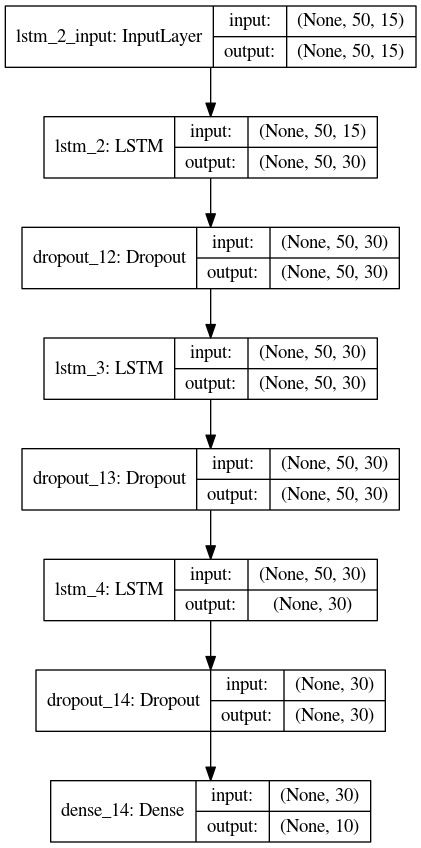

In [43]:
lstm_classif = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                Dropout(0.2),
                LSTM(units=30, return_sequences=True),
                Dropout(0.2),
                LSTM(units=30),
                Dropout(0.2),
                Dense(Y_train_one_hot.shape[1], activation='softmax')
                ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif2.png', show_shapes=True)
Image.open('lstm_classif2.png')

## Compiling Model

In [44]:
lstm_classif.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [45]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=4, validation_split=0.1, verbose=2, shuffle=False)

Train on 2187 samples, validate on 243 samples
Epoch 1/30
 - 44s - loss: 2.2464 - accuracy: 0.1427 - val_loss: 2.1947 - val_accuracy: 0.2099
Epoch 2/30
 - 42s - loss: 2.2516 - accuracy: 0.1550 - val_loss: 2.1889 - val_accuracy: 0.2099
Epoch 3/30
 - 43s - loss: 2.2443 - accuracy: 0.1436 - val_loss: 2.1894 - val_accuracy: 0.2099
Epoch 4/30
 - 42s - loss: 2.2446 - accuracy: 0.1481 - val_loss: 2.1876 - val_accuracy: 0.2099
Epoch 5/30
 - 42s - loss: 2.2408 - accuracy: 0.1509 - val_loss: 2.1877 - val_accuracy: 0.2099
Epoch 6/30
 - 42s - loss: 2.2407 - accuracy: 0.1472 - val_loss: 2.1903 - val_accuracy: 0.2099
Epoch 7/30
 - 42s - loss: 2.2362 - accuracy: 0.1527 - val_loss: 2.1864 - val_accuracy: 0.2099
Epoch 8/30
 - 42s - loss: 2.2352 - accuracy: 0.1527 - val_loss: 2.1857 - val_accuracy: 0.2099
Epoch 9/30
 - 42s - loss: 2.2348 - accuracy: 0.1491 - val_loss: 2.1723 - val_accuracy: 0.2099
Epoch 10/30
 - 42s - loss: 2.2357 - accuracy: 0.1459 - val_loss: 2.1865 - val_accuracy: 0.2099
Epoch 11/30


## Visualizing Training Stage Results

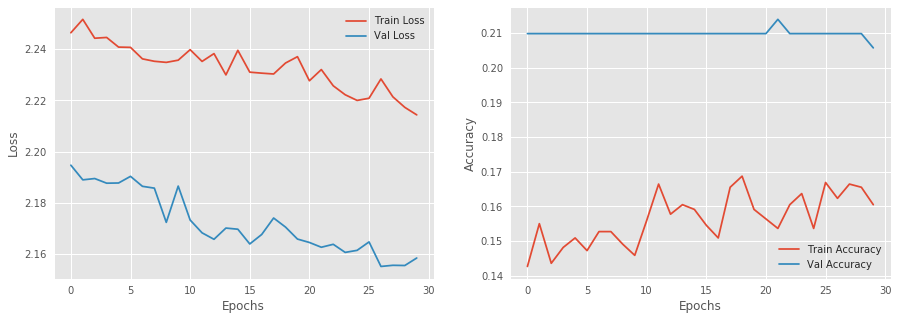

In [46]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [47]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.177


In [48]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))

Accuracy : 0.167


In [49]:
softmax_vals = lstm_classif.predict_proba(X_new)
#print(softmax_vals[:,i].shape)
df4 = copy.deepcopy(data)
df4['Preds'] = np.hstack((['label_down_200']*50, predictions_full))
for i, col in enumerate(target_col_order):
    df4[col + '_softmax'] = np.hstack((np.zeros(50), softmax_vals[:,i]))

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.24      0.37      0.29        27
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        26
           4       0.16      0.38      0.23        32
           5       0.16      0.65      0.26        26
           6       0.00      0.00      0.00        30
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        17
           9       0.20      0.04      0.07        23

    accuracy                           0.18       226
   macro avg       0.08      0.14      0.09       226
weighted avg       0.09      0.18      0.10       226

Confusion Matrix : 
 [[10  0  0  0 10  5  0  0  0  2]
 [ 1  0  0  0  5  4  0  0  0  0]
 [ 2  0  0  0  4  6  0  0  0  0]
 [ 6  0  0  0  8 12  0  0  0  0]
 [ 2  0  0  0 12 17  0  0  0  1]
 [ 4  0  0  0  5 17  0  0  0 

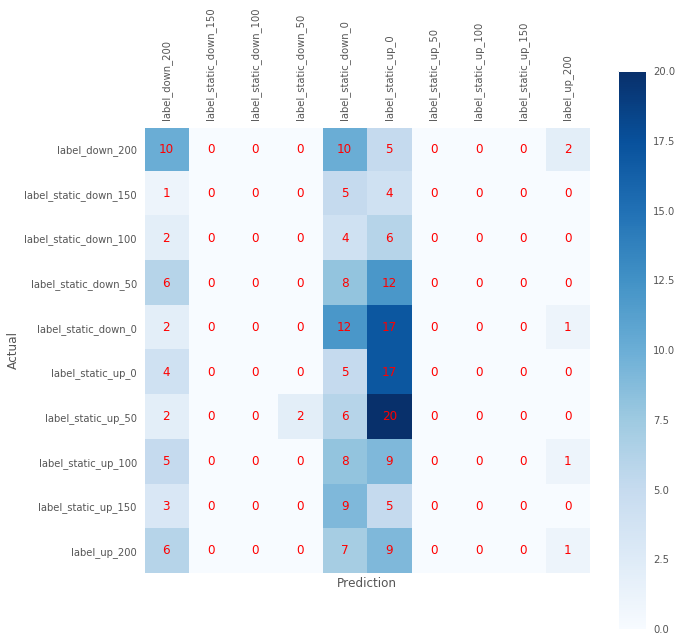

In [50]:
print_plot_metrics('LSTMv2' , actual_rets_test, Y_test, predictions)

## Visualising Weights

Layer : LSTM : Weights : (15, 120)
Layer : LSTM : Weights : (30, 120)
Layer : LSTM : Weights : (120,)
Layer : Dense : Weights : (30, 120)
Layer : Dense : Bias : (30, 120)


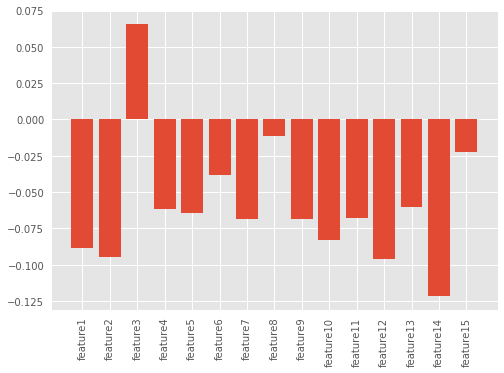

In [51]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

In [52]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('DenseNetv1',df1), ('DenseNetv2',df2), ('LSTMv1', df3), ('LSTMv2', df4)]:
        df1.to_excel(writer, sheet_name= sheet_name)

In [53]:
from IPython.display import FileLink
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx